In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.parallel
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
import time
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
warnings.filterwarnings("ignore")

In [3]:
torch.cuda.empty_cache()
cudnn.benchmark = True

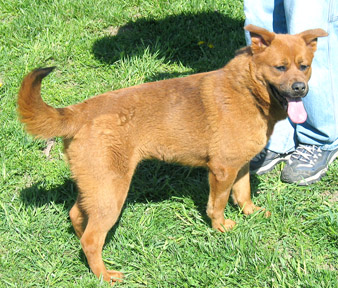

In [4]:
with Image.open('dataset/CATS_DOGS/test/DOG/9381.jpg') as im:
    display(im)

In [5]:
path = 'dataset/CATS_DOGS/'
img_names = []

for folders, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folders + '/' + img)

print(len(img_names))

24994


In [6]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
        
print(len(img_sizes),'\n',len(rejected))        

24994 
 0


In [7]:
df = pd.DataFrame(img_sizes, columns=['width', 'height'])

In [8]:
df.head()

,width,height
0,431,360
1,500,375
2,500,471
3,500,375
4,320,240


In [9]:
print(f"Width:\n\n{df['width'].describe()}\n\n")
print(f"Height:\n\n{df['height'].describe()}")

Width:

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: width, dtype: float64


Height:

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: height, dtype: float64


In [10]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
root = 'dataset/CATS_DOGS/'

train = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

In [13]:
train_loader = DataLoader(train, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size=10, shuffle=False, num_workers=4, pin_memory=True)

In [14]:
class_names = train.classes

In [15]:
for images, labels in train_loader:
    break

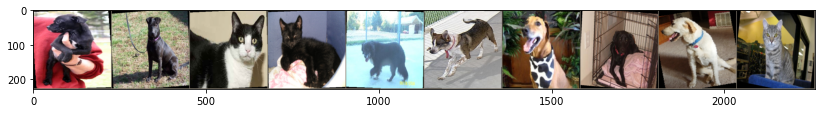

In [16]:
im = make_grid(images, nrow=16) 

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

plt.figure(figsize=(14,8))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [17]:
vgg = models.vgg16_bn(pretrained=True).cuda()

print(f"Base Model:\n\n{vgg}")

for param in vgg.parameters():
    param.requires_grad = False
    
vgg.classifier = nn.Sequential(nn.Linear(25088, 4096),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),
                        nn.Linear(4096, 2048),
                        nn.LeakyReLU(negative_slope=0.2, inplace=True),       
                        nn.Linear(2048, 2),       
                        nn.LogSoftmax(dim=1))

print(f"New Model:\n\n{vgg}")

Base Model:

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Co

In [18]:
vgg = vgg.cuda()

In [19]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(vgg.classifier.parameters(), momentum=0.9, lr=0.0003, weight_decay=5e-4)
epochs = 10
losses = []
val_losses = []
correct = []
val_correct = []

In [20]:
start_time = time.time()

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    e_start = time.time()
    
    for b, (X_train, y_train) in enumerate(train_loader):      
        if b == max_trn_batch:
            break
        
        b+=1
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        y_pred = vgg(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%800 == 0:
            e_end = time.time()
            print(f'Epoch {(i+1):2}\nAccuracy: {trn_corr.item()*100/(10*b):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break
            
            X_test = X_test.cuda()
            y_test = y_test.cuda()

            y_val = vgg(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val.cuda(), y_test.cuda())
    print(f'Validation Loss: {loss.item():2.4f}\n')
    test_losses.append(loss)
    test_correct.append(tst_corr)

end_time = time.time() - start_time    
    
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch  1
Accuracy: 95.59 %  Loss: 0.0314  Duration: 3.78 minutes
Validation Loss: 0.1451

Epoch  2
Accuracy: 97.44 %  Loss: 0.2679  Duration: 4.24 minutes
Validation Loss: 0.1537

Epoch  3
Accuracy: 98.10 %  Loss: 0.0007  Duration: 4.62 minutes
Validation Loss: 0.2154

Epoch  4
Accuracy: 98.12 %  Loss: 0.0530  Duration: 4.82 minutes
Validation Loss: 0.2561

Epoch  5
Accuracy: 98.34 %  Loss: 0.1462  Duration: 4.93 minutes
Validation Loss: 0.1664

Epoch  6
Accuracy: 98.51 %  Loss: 0.0004  Duration: 4.97 minutes
Validation Loss: 0.2164

Epoch  7
Accuracy: 98.44 %  Loss: 0.0016  Duration: 4.50 minutes
Validation Loss: 0.2734

Epoch  8
Accuracy: 98.64 %  Loss: 0.0155  Duration: 4.26 minutes
Validation Loss: 0.1162

Epoch  9
Accuracy: 98.36 %  Loss: 0.0196  Duration: 4.29 minutes
Validation Loss: 0.2827

Epoch 10
Accuracy: 98.70 %  Loss: 0.0015  Duration: 4.33 minutes
Validation Loss: 0.0839


Training Duration 57.77 minutes
GPU memory used : 1393793024 kb
GPU memory cached : 2550136832 kb


In [21]:
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

Test accuracy: 93.067%


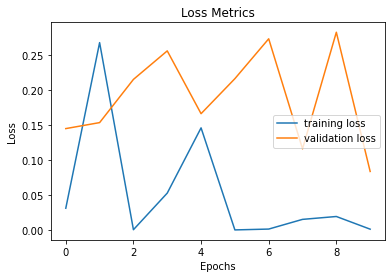

In [22]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

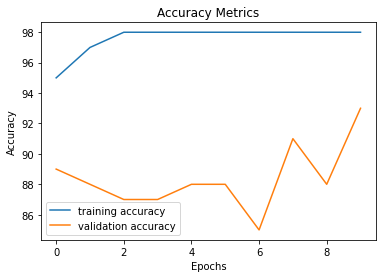

In [23]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [24]:
torch.save(vgg.state_dict(), 'models/cats_vgg_dogs.pt')